<a href="https://colab.research.google.com/github/danidmvz/SPARSEwithRL/blob/main/SPARSEsine1D/SPARSEsine1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPARSE with stochastic forcing: what is the optimal forcing function?** 

In this code I present a one-dimensional version of the SPARSE method with stochastic forcing (S-SPARSE) to describe the agent that is trying to minimize some Quantity of Interest (QoI) as it might be the particle spread (standard deviation of the particle positions) $\sigma_{x_p}$.

The agent: macro-particle, learns the stochastic forcing function $f(\boldsymbol \alpha,\boldsymbol a)=\sum_i^{N}\alpha_i \Psi_i(\boldsymbol a)$ and in particular its coefficients stuck in the vector $\boldsymbol \alpha$. The basis functions $\Psi_i$ are chosen according to the Chebyshev modes of the first kind of a correlation. In this case I use the Schiller and Naumann correlation $f(Re_p)=1+0.15Re_p^{0.687}$.

The agent learns to control the second moments of the stochastic coefficients $\overline{\alpha_i^\prime \alpha_j^\prime}$ to minimize the cost function that is defined such that the particle spread is minimum. The agent is trained using maximum a posteriori policy optimization ([mpo](https://arxiv.org/abs/1806.06920)). The deep reinforcment learning framework [acme](https://github.com/deepmind/acme), developed by DeepMind, is used to train the agent.

The notebook describes in order: 
- The environment components and  the implementation architecture required by [dm_control](https://github.com/deepmind/dm_control).
- The agent set-up and training loop. 
- The evaluation of the trained agent when applied to the environment. 

# Install acme


In [437]:
# Install acme
#!pip install virtualenv
#!pip install --upgrade pip setuptools wheel
#!virtualenv .acme
#!source .acme/bin/activate

# A fixed release version of dm-acme and dm-control is enforced for long term maintenance
#!pip install dm-acme[tf]==0.3.0 
#!pip install dm-control==0.0.364896371

In [480]:
# Import
from dm_control.rl.control import Environment
import numpy as np
import matplotlib.pyplot as plt

from acme import agents, specs
from acme.environment_loop import EnvironmentLoop
from acme.wrappers.single_precision import SinglePrecisionWrapper
from acme.wrappers.canonical_spec import CanonicalSpecWrapper
from acme.agents.tf import mpo
from acme.tf import networks
from acme.tf import utils as tf2_utils
import sonnet as snt
from acme.utils import paths
import tensorflow as tf 
from acme.utils.loggers import tf_summary
from __future__ import annotations
import numpy as np
from dm_control.rl import control


#  **Water tank environment**

## Physics model
The ordinary differential equation governing the evolution of the water level $h$ in the tank, provided the appropriate physical scaling, can be written as,
\begin{align}
\frac{d h}{d t} = w_{out} + w_{in}.
\end{align}

The following constitutive equation is assumed for the water outflow in the nozzle,
\begin{align}
w_{out} = - \alpha \sqrt{h}.
\end{align}

The equation is discretized in time with Euler explicit scheme,
\begin{align}
h^{t+1} = dt_{sim}*(w_{out}^{t} + w_{in}^{t}) + h^{t}  
\end{align}


## Environment in dm_control framework

To make use of [acme](https://github.com/deepmind/acme) architecture for continuous control purposes it's convenient to implement the environment following the [dm_control](https://github.com/deepmind/dm_control) architecture. This allows to benefit from several tools and routines to simplify the set-up of the training.

The [dm_control](https://github.com/deepmind/dm_control) framework requires to define the environment as a combination of a **physics** simular and one or multiple **tasks**. 

---


### physics
The main component of the **physics** simulator, given the actions, is to step in time the ode. This is done in the `step` method.

Numerical checks for the solution as well as sanity checks to avoid non physical state of the system are included in the `check_divergence` method.  

In [497]:
class Physics(control.Physics):
    """Water tank environment built on the dm_control.Environment class."""
    def __init__(
        self,
        alpha: float, 
        dt_sim: float,
        hmax: float,
        init_state,
        init_action,
        ):
        """Initializes water tank

        Attributes:
            alpha: nozzle outflow coefficient
            dt_sim:  [s] Discretization time interval for sim
            hmax: [m] max water height in tank
            init_state: [m] initial water height        
        """
        self._alpha = alpha
        self._dt_sim = dt_sim
        self._h_max = hmax
        self._init_state = init_state
        self._state = self._init_state
        self._time = 0.
        self._init_action = init_action #  np.asarray([0. ,0.])
        self._action = self._init_action
        #print('builder')
        #print(self._action)
        #print(self._action[0])
        #print(self._action[1])
        # self._rhs =  np.zeros([1], dtype = float)
        # y has: [mean_xp, mean_up, xpxp, xpup, upup, alpha1xp, ... , alpha5xp, 
        # alpha1up, ..., alpha5up]
        #self._y = y 

    def reset(self):
        """Resets environment physics"""
        self._state = self._init_state
        self._time = 0.
        self._action = self._init_action #  np.zeros((2,1)) # np.asarray([0., 0.])

    def after_reset(self):
       pass

    def step(self, n_sub_steps = 1):
        """Updates the environment according to the action"""

        # Euler explicit time step
        self._state = self._dt_sim*self._RHS() + self._state

        # Update sim time
        self._time += self._dt_sim

        # Keep h min at 0
        # if self._state[0] <= 0.: self._state[0] = 0.

    def _RHS(self):
        """ Returns Physical RHS for ODE d state / dt = F(state, action) """
        #print(self._action[1])
        #print(-self._alpha*np.sqrt(self._state[0]))
        rhs1 = -self._alpha*np.sqrt(self._state[0]) + self._action[0]
        rhs2 = -self._alpha*np.sqrt(self._state[1]) + self._action[1]
        return np.append(rhs1, rhs2)

    def _Forcing(self):


        return 

    def time(self):
        """Returns total elapsed simulation time"""
        return self._time

    def timestep(self):
        """Returns dt simulation step"""
        return self._dt_sim

    def check_divergence(self):
        """ Checks physical terminations:
         - water reached maximum level
         - physical states not finite
         """
        if  self._state[0] >= self_hmax:
            raise control.PhysicsError(
                f'h > max value = {self._hmax} [m]'
            )

        if not all(np.isfinite(self._state)):
            raise control.PhysicsError('System state not finite')

    def set_control(self, action):
        """Sets control actions""" 
        self._action = action 

    def get_state(self):
        """Returns physical states"""
        return self._state

### task
Each **task** has several purposes:

-  Initialize the physics.

For example, initializing the initial water level. This could differ from task to task.

-  Define the reward function, hence the control target

In this tutorial we will consider a Step target, which aims to keep the water level constant during a first time interval and then step the level to a different constant target. The reward function is defined as a normal distribution, with the mean equal to the target water level at a given time and the standard deviation $\sigma$ set to $0.05m$. A well trained agent should be able to control the water level with a precision $\sim \sigma$. 

-  Provide the observations to be sent to the actor given the state of the system and the control target for the task.

Each task could potentially observe a different subset of the system state. In this tutorial the agent will observe directly the water level, hence the full physical state. In order to let the agent learn how to deal with a time varying target, together with the physical state, we let the system observe the water level desired target.

- Define physical limits for the actions.   


In [498]:
class Step(control.Task):
    """ Step task:
    Keep constant value and step to different constant value at t_step
    """

    def __init__(self,
                 maxinflow: float,
                 # h_goal1: float,
                 # h_goal2: float,
                 h_avg: float,
                 t_step: float,
                 precision: float,
                 targets,
                 ):
        """Initialize Step task
        
        Parameters:
            maxinflow: max control inflow
            h_goal1: [m] target height 1st time interval
            h_goal2: [m] target height 2nd time interval
            t_step:  [s] switching time instant 1st->2nd target  
            precision: [m] desired precision on h target   
        
        """
        self._maxinflow = maxinflow
        #self._h_goal1 = h_goal1
        #self._h_goal2 = h_goal2
        self._h_avg = h_avg # This is the average of the sinusoidal trend
        self._t_step = t_step
        self._precision = precision
        self._targets = targets


    def initialize_episode(self, physics):
        """ Reset physics for the task """
        physics.reset()

    def get_reference(self, physics):
        """Returns target reference"""
        #if physics.time() < self._t_step:
        #    target = self._h_goal1
        #else:
        #    target = self._h_goal2
        self._targets[0] = self._h_avg + 0.1*np.sin(5*physics.time()) # sinusoidal signal of the height
        self._targets[1] = self._h_avg + 0.1*np.cos(5*physics.time())
        return self._targets

    def get_observation(self, physics):
        """Returns specific observation for the task"""
        # Let the actor observe the reference and the state
        #print('self.get_reference(physics)')
        #print(self.get_reference(physics))
        
        #print('physics.get_state()')
        #print(physics.get_state())

        #print('get_observation')
        #print(np.concatenate((self.get_reference(physics), physics.get_state()), axis=None))
        return np.concatenate((self.get_reference(physics), physics.get_state()))

    def get_reward(self, physics):
        """Returns the reward given the physical state """
        sigma = self._precision
        mean = self.get_reference(physics)
        # Gaussian like rewards on target water level h
        return np.exp(
            -np.power(physics.get_state()[0] - mean[0], 2.)/(2*np.power(sigma, 2.))
        )

    def before_step(self, action, physics):
        physics.set_control(action)
     
    def observation_spec(self, physics):
        """Returns the observation specifications"""
        return specs.Array(
            shape=(4,),
            dtype=np.float32,
            name='observation')

    def action_spec(self, physics):
        """Returns the action specifications"""
        return specs.BoundedArray(
            shape=(2,),
            dtype=np.float32,
            minimum=0.,
            maximum=self._maxinflow,
            name='action')


## Simulate the environment with null actions
We can now instantiate the environment and simulate it with null actions to get some intuition of the different components.

Instance of `physics`, `task` and `environment`.

In [499]:
physics = Physics(
    alpha= 1.0, 
    dt_sim=0.05,  
    hmax=5,   
    init_state=[1., 2.],  
    init_action = [0.1, 0.2],
    #init_state=[1.],  
    #init_action = [0.1],
    )

task = Step(
    maxinflow = 5., 
    # h_goal1 = 1., 
    # h_goal2 = 0.8, 
    h_avg = 1.,
    t_step = 1., 
    precision = 0.05, 
    targets = [0., 0.],
    #targets = [0.],
)

environment = Environment(
    physics,
    task,
    time_limit=3, 
) 

Simulate with null action

In [468]:
# Reset the environmentb
TimeStep = environment.reset()

In [469]:
# Define constant 0 actions
actions = np.zeros(environment.action_spec().shape, np.float32)

In [444]:
actions

array([0., 0.], dtype=float32)

In [445]:
TimeStep.observation.tolist()

[1.0, 1.1, 1.0, 2.0]

In [446]:
TimeStep.reward

In [447]:
environment.physics.time()

0.0

In [448]:
TimeStep = environment.step(actions)

In [500]:
# Reset the environment
TimeStep = environment.reset()
    
# Define constant 0 actions
actions = np.zeros(environment.action_spec().shape, np.float32)

# Simulate environment and store state,observation,reward,time
s, o, r, t = [],[],[],[]
while not TimeStep.last():
  s.append(environment._physics._state)
  o.append(TimeStep.observation.tolist())
  r.append(TimeStep.reward)
  t.append(environment.physics.time())
  TimeStep = environment.step(actions)

<ipython-input-497-ead65fefcdc6>:61: RuntimeWarning: invalid value encountered in sqrt
  rhs1 = -self._alpha*np.sqrt(self._state[0]) + self._action[0]
<ipython-input-497-ead65fefcdc6>:62: RuntimeWarning: invalid value encountered in sqrt
  rhs2 = -self._alpha*np.sqrt(self._state[1]) + self._action[1]


As expected the water level drops from the initial level $h = 1$ to $0$.

Text(0.5, 0, 'time [s]')

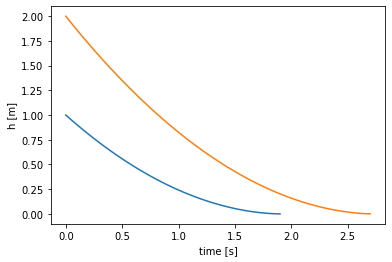

In [501]:
# Plot system state evolution
plt.plot(t,s)
plt.ylabel('h [m]')
plt.xlabel('time [s]')

We can check the observations in time that the task `Step` will provide to the agent. As you can see in the figure, the `target` level is provided to the observations together with the `state` to allow the agent learning to follow the target in time.

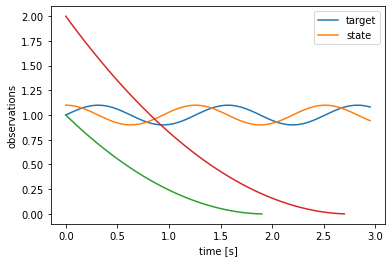

In [502]:
# Plot observation
plt.plot(t,o)
plt.ylabel('observations')
plt.xlabel('time [s]')
plt.legend(['target','state'])

We can also check the time trace of the rewards provided by the task. Given the normal definition centered at the target, the reward drops while the water level gets further from the target. 

Text(0.5, 0, 'time [s]')

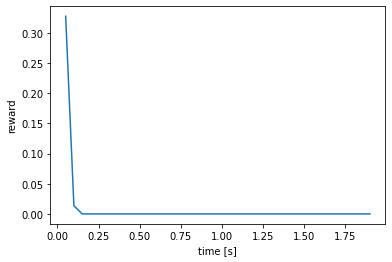

In [503]:
# Plot reward
plt.plot(t,r)
plt.ylabel('reward')
plt.xlabel('time [s]')

# **MPO Agent**

In the following section we will show how to train an MPO agent for the environment and task. 
The section is taken mainly from the official [acme](https://github.com/deepmind/acme) tutorial in the following colab <a href="https://colab.research.google.com/github/deepmind/acme/blob/master/examples/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>. We invite to check the official tutorial for a more detailed explanation. 

In [504]:
# Set random seed for example reproducibility
tf.random.set_seed(1500)

First of all we make use of wrappers to wrap the environment in order to bound the allowed actions within specifications defined in task. We also cast the I/O of the environment into single precision. 

In [505]:
# Clip actions by bounds
environment = CanonicalSpecWrapper(environment= environment,clip= True) 

# Wrap to single precision
environment = SinglePrecisionWrapper(environment) 

# Extract environment specifications
environment_spec = specs.make_environment_spec(environment)

## Set-up

The next step is to set-up the NN used by the agent. MPO is a somewhat complicated algorithm, so we'll leave a full explanation of this method to the accompanying  [paper](https://arxiv.org/abs/1806.06920). 

However, we give here below some hints to understand the meaning of the following code. The `mpo` is an actor-critic algorithm. 
- The `actor` provides the actions given the state (of the agent). In this simple example the state of the agent consists directly on the observations, i.e. the state of the physical system (water level) and the target level. The actor contains the policy, which ultimately represents the control low to decide the inflow given the actor state (water level).  
- The `critic` learns the state-action value function, which is related to the expected sum of future rewards, given a certain state and a taken action. This function provides intuitively the information on the value of taking a certain action being on a certain state. The critic is used during the learning process to update the policy. 

The `actor` and `critic` functions are approximated with NNs as [sonnet](https://github.com/deepmind/sonnet) MLP modules.

MPO uses a distributional `actor`, as it can be seen from the `MultivariateNormalDiagHead`, which means that the policy obtained is not deterministic. The `policy_network` will return the mean and standard deviation of Normal distribution and the `actor` will sample from this distribution in order to get the actions to be applied to the environment. 

The [acme](https://github.com/deepmind/acme) architecture provides the possibility to specify a neural network for the observations. This is useful for example when dealing with observations coming from images to distil a simple agent state from pixel like information to be given to the critic. In this tuorial, the single physical state $h$ is directly observed and the observation network is simply an identity. 

The `multiplex` combines the actions and observations to be given as inputs to the critic network. 

Overall in general, for the mpo algorithm, one needs to specify 3 NNs for the `actor(policy)_net`, the `critic_net` and  the `observation_net`. 



In [494]:
# Get total number of action dimensions from action spec.
num_dimensions = np.prod(environment_spec.actions.shape, dtype=int)
num_dimensions

1

In [456]:
# Create the shared observation network; here simply a state-less operation.
observation_network = tf2_utils.batch_concat
observation_network

<function acme.tf.utils.batch_concat(inputs: Any) -> tensorflow.python.framework.ops.Tensor>

In [457]:
# Specify default dimension for MLP
policy_layer_sizes = [16,16]
critic_layer_sizes = [16,16]

# Create the policy network.
policy_network = snt.Sequential([
  networks.LayerNormMLP(policy_layer_sizes),
  networks.MultivariateNormalDiagHead(num_dimensions),
])
policy_network

Sequential(
    layers=[LayerNormMLP(layer_sizes=[16, 16]),
            MultivariateNormalDiagHead(num_dimensions=2)],
)

In [458]:
critic_layer_sizes = list(critic_layer_sizes) + [1] # Hack to conform to mpo implementation
# Create the critic network
critic_network = networks.CriticMultiplexer(critic_network=networks.LayerNormMLP(critic_layer_sizes))
critic_layer_sizes
critic_network

CriticMultiplexer(critic_network=LayerNormMLP(layer_sizes=[16, 16, 1]))

In [459]:
# Pack agent networks
agent_networks = {
      'policy': policy_network,
      'critic': critic_network,
      'observation': observation_network,
  }
agent_networks

{'policy': Sequential(
     layers=[LayerNormMLP(layer_sizes=[16, 16]),
             MultivariateNormalDiagHead(num_dimensions=2)],
 ),
 'critic': CriticMultiplexer(critic_network=LayerNormMLP(layer_sizes=[16, 16, 1])),
 'observation': <function acme.tf.utils.batch_concat(inputs: Any) -> tensorflow.python.framework.ops.Tensor>}

In [506]:
# Get total number of action dimensions from action spec.
num_dimensions = np.prod(environment_spec.actions.shape, dtype=int)

# Create the shared observation network; here simply a state-less operation.
observation_network = tf2_utils.batch_concat

# Specify default dimension for MLP
policy_layer_sizes = [16,16]
critic_layer_sizes = [16,16]

# Create the policy network.
policy_network = snt.Sequential([
  networks.LayerNormMLP(policy_layer_sizes),
  networks.MultivariateNormalDiagHead(num_dimensions),
])

critic_layer_sizes = list(critic_layer_sizes) + [1] # Hack to conform to mpo implementation
# Create the critic network
critic_network = networks.CriticMultiplexer(critic_network=networks.LayerNormMLP(critic_layer_sizes))

# Pack agent networks
agent_networks = {
      'policy': policy_network,
      'critic': critic_network,
      'observation': observation_network,
  }


Having specified the network architectures, we can finally define the agent, which combines the environment, the actor and the critic. Internally, the MPO agent contains the learner to update the policy.

In [496]:
environment_spec

EnvironmentSpec(observations=Array(shape=(1,), dtype=dtype('float32'), name='observation'), actions=BoundedArray(shape=(1,), dtype=dtype('float32'), name='action', minimum=[-1.], maximum=[1.]), rewards=Array(shape=(), dtype=dtype('float32'), name='reward'), discounts=BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0))

In [507]:
agent = mpo.MPO(
 environment_spec = environment_spec,
 policy_network = agent_networks['policy'],
 critic_network = agent_networks['critic'],
 observation_network = agent_networks['observation'], 
 batch_size = 40,
 target_policy_update_period = 5,
 target_critic_update_period = 5,
 min_replay_size = 10,
 checkpoint = False,
)
    

We define a tensorboard logger to store logs during training and inspect the learning curve afterwards.

In [477]:
outpath = '/content' # Destination of tensorboard log file
logger = tf_summary.TFSummaryLogger(logdir = outpath)

## Training
Finally we can train the agent. (With 200 episodes it will take ~2 min).

In [508]:
num_episodes = 200 

# Run the environment loop.
loop = EnvironmentLoop(environment, agent, logger = logger)

# 350 is a good trainin
loop.run(num_episodes=200)

# Visualize training logs with tensorboard

It is convenient to visualize the training results in tensorboard. 
The main plot to observe is the episode return increase (~sum of the reward during an episode) over episodes, which tells how fast the agent is learning. 

Given that the simulation was set to last $2.5s$ with a $dt_{sim}$ of $0.05s$, we expect each episode to last $50$ time steps unless a physical limit defined in `physics` is hit, such as if the water exceed the maximum height.

The maximum reward per time step is $1$, hence the maximum return per episode, given by the sum of the discounted rewards, is $\sim50$. (discount factor is set to 0.99).

We can see that the trained agent achieves an episode return of $\sim 45$.

Another interesting plots is the `StepsPerSecond` which tells how fast is the simulation of a single physical time step. Improving the speed of the environment allows to accelerate the collection of the experience for the learning process. 


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content

# Trained agent evaluation

Now that we trained an agent and inspected its learning properties, we can use the policy obtained and evaluate how it performs in controlling the water level in the `tank`. 

First we simulate the environment with the trained policy.

In [510]:
# Evaluate 
TimeStep = environment.reset()
# Run episode and store system state, observation, action, reward and time
s, o, a, r, t = [],[],[],[],[]
while not TimeStep.last():
  s.append(environment._physics._state)
  o.append(TimeStep.observation.tolist())
  r.append(TimeStep.reward)
  t.append(environment.physics.time())
  actions = agent.select_action(np.float32(TimeStep.observation)) 
  a.append(actions)
  TimeStep = environment.step(actions)   

We can now observe how the agent has learnt to control the $w_{in}$ to follow the target water level desired. We recall that the reward was designed as a Normal distribution centered on the target, and with $\sigma = 0.05 m$. The trained policy achieved a tracking precision of $\sim  0.05 m$ as expected.

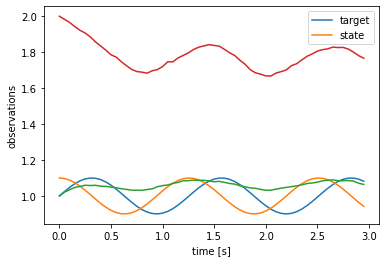

In [511]:
# Plot observation
plt.plot(t,o)
plt.ylabel('observations')
plt.xlabel('time [s]')
plt.legend(['target','state'])


The instantaneous rewards during the simulation with the trained agent are always close to the maximum value $=1$, except during the step instant. In this moment, the time decay of the water level is limited by the physical time scales of the system.

Text(0.5, 0, 'time [s]')

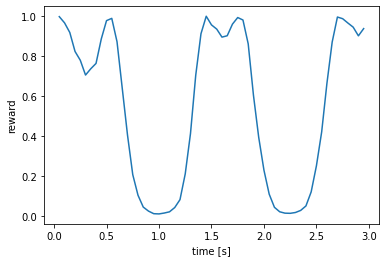

In [512]:
# Plot reward
plt.plot(t,r)
plt.ylabel('reward')
plt.xlabel('time [s]')

We can also investigate the actions produced by the policy. Since we used the `CanonicalSpecWrapper` to clip the actions by physical bounds specified in task, the trained policy will provide actions in the $[-1,1]$ canonical interval. We need therefore to transform the actions to convert the inflow in SI units in the $[0,maxinflow]$ interval. This convertion is done internally when using `EnvironmentLoop` during training.

Text(0.5, 0, 'time [s]')

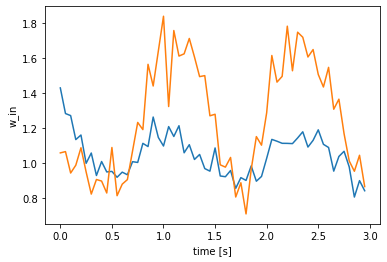

In [513]:
# Revert action from canonical representation [-1,1] to SI 
f = lambda x: (np.clip(np.asarray(x),-1,1) + 1)*task._maxinflow/2 
a = [f(x) for x in a]

# Plot reward
plt.plot(t,a)
plt.ylabel('w_in')
plt.xlabel('time [s]')

# Summary

In this tutorial we showed how to implement a simple physical ode environment  following the [dm_control](https://github.com/deepmind/dm_control) requirements. Then, we trained an mpo agent with [acme](https://github.com/deepmind/acme) framework to perform continuous action space control.

Using deep reinforcement learning for this simple task and environment is obviously an overkill. However an extremely simple environment allows to play with deep reinforcement learning solutions at low computational costs. On top of that, making use of high quality frameworks such as [acme](https://github.com/deepmind/acme) allows potentially to easily scale up and generalize the approach.